In [7]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, spearmanr
import mplcursors
import EpiClockNBL.src.util as pc_util
nbl_consts = pc_util.consts

In [8]:
proj_dir = os.path.join(nbl_consts['official_indir'], 'Heinrich')
gmm_peak_indir = os.path.join(nbl_consts['repo_dir'], 'Gaussian Mixture Model')

In [9]:
figure_outdir = 'figures'
os.makedirs(figure_outdir, exist_ok=True)

## Prepare data

In [10]:
os.path.join(proj_dir, 'Henrich.methyl.antiNonIterClustNotStuck_sites.tsv')

'/Users/grahamgumbert/Library/CloudStorage/Box-Box/PROJECT 06023: MolClocks/Neuroblastoma_Paper/Datasets/Heinrich/Henrich.methyl.antiNonIterClustNotStuck_sites.tsv'

In [15]:
clinical = {}
clinical['HEINRICH'] = pd.read_table(os.path.join(proj_dir, 'sample_annotations_clean.txt'), index_col=1)

# Import Clock beta values for TCGA
beta_values_Clock = pd.read_table(os.path.join(proj_dir, 'Henrich.methyl.antiNonIterClustNotStuck_sites.tsv'),
                      index_col=0).rename(columns=pc_util.sampleToPatientID)

clinical['HEINRICH']['c_beta'] = 1 - beta_values_Clock.std()

display(clinical['HEINRICH'])

,Unnamed: 0,Sample_status,Sample_submission_date,Sample_last_update_date,Sample_type,Sample_channel_count,Sample_source_name_ch1,Sample_organism_ch1,inss stage,current risk category,...,Sample_contact_department,Sample_contact_institute,Sample_contact_address,Sample_contact_city,Sample_contact_zip/postal_code,Sample_contact_country,Sample_supplementary_file,Sample_supplementary_file.1,Sample_data_row_count,c_beta
Sample_geo_accession,,,,,,,,,,,,,,,,,,,,,
GSM1896914,genomic DNA from neuroblastoma tumor 1,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 1,Homo sapiens,4,intermediate-risk,...,Biostatistics,German Cancer Research Center,Im Neuenheimer Feld 280,Heidelberg,69120,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,382182,0.733275
GSM1896915,genomic DNA from neuroblastoma tumor 2,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 2,Homo sapiens,4,high-risk,...,Biostatistics,German Cancer Research Center,Im Neuenheimer Feld 280,Heidelberg,69120,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,382182,0.816997
GSM1896916,genomic DNA from neuroblastoma tumor 3,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 3,Homo sapiens,2.1,low-risk,...,Biostatistics,German Cancer Research Center,Im Neuenheimer Feld 280,Heidelberg,69120,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,382182,0.829792
GSM1896917,genomic DNA from neuroblastoma tumor 4,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 4,Homo sapiens,4,high-risk,...,Biostatistics,German Cancer Research Center,Im Neuenheimer Feld 280,Heidelberg,69120,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,382182,0.802420
GSM1896918,genomic DNA from neuroblastoma tumor 5,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 5,Homo sapiens,1,low-risk,...,Biostatistics,German Cancer Research Center,Im Neuenheimer Feld 280,Heidelberg,69120,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,382182,0.833438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1897036,genomic DNA from neuroblastoma tumor 101,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 101,Homo sapiens,4,high-risk,...,Biostatistics,German Cancer Research Center,Im Neuenheimer Feld 280,Heidelberg,69120,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1897...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1897...,382182,0.815101
GSM1897037,genomic DNA from neuroblastoma tumor 102,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 102,Homo sapiens,4S,low-risk,...,Biostatistics,German Cancer Research Center,Im Neuenheimer Feld 280,Heidelberg,69120,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1897...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1897...,382182,0.825864
GSM1897038,genomic DNA from neuroblastoma tumor 103,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 103,Homo sapiens,4S,low-risk,...,Biostatistics,German Cancer Research Center,Im Neuenheimer Feld 280,Heidelberg,69120,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1897...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1897...,382182,0.839253


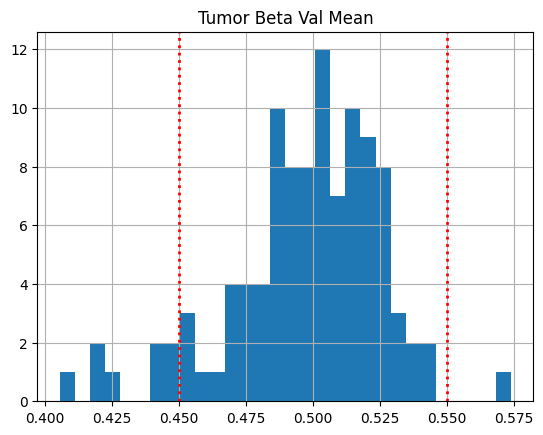

In [16]:
mean_beta_values = beta_values_Clock.mean(axis=0)

fig, ax = plt.subplots()
mean_beta_values.hist(bins=30, ax=ax)
ax.set_title("Tumor Beta Val Mean")

ax.axvline(x=0.45, color='red', linestyle='dotted', linewidth=2)
ax.axvline(x=0.55, color='red', linestyle='dotted', linewidth=2)

plt.show()

bad_mean_tumors = beta_values_Clock.mean(axis=0)[(beta_values_Clock.mean(axis=0) < 0.45) | (beta_values_Clock.mean(axis=0) > 0.55)]

good_mean_tumors = beta_values_Clock.columns.difference(bad_mean_tumors.index)

with open(os.path.join(nbl_consts['repo_dir'], "data", "good_mean_tumors.txt"), "w") as f:
    for tumor in good_mean_tumors:
        f.write(f"{tumor}\n")

### Gaussian Mixture Model data

In [20]:
gmm_params = {}

for dataset in ['HEINRICH']:
    print()
    print(dataset)
    
    # Import GMM decomposition raw outputs
    # i.e. GMM's parameters and weights
    gmm_params[dataset] = pd.read_csv(os.path.join(gmm_peak_indir, "TARGET", 'tumor_params_GMM_summary_Heinrich.csv'))

    gmm_params[dataset].rename(columns={"Tumor": "submitter_id"}, inplace=True)
    
    gmm_params[dataset]["submitter_id"] = (
        gmm_params[dataset]["submitter_id"]
        .str.replace(r"\.01[ABC]$", "", regex=True)
        .str.replace(r"\.", "-", regex=True)
    )
    
    gmm_params[dataset].set_index("submitter_id", inplace=True)
    
    clinical[dataset]['gmm_X'] = gmm_params[dataset]["X_mean"]
    
    clinical[dataset]['gmm_phi'] = gmm_params[dataset]["phi_mean"]

    clinical[dataset]['psi_1_mean'] = gmm_params[dataset]["psi_1_mean"]

    clinical[dataset]['psi_2_mean'] = gmm_params[dataset]["psi_2_mean"]

    clinical[dataset]['psi_3_mean'] = gmm_params[dataset]["psi_3_mean"]
    
    clinical[dataset] = clinical[dataset].loc[~clinical[dataset]['gmm_phi'].isna()]

    clinical[dataset].name = "TARGET"

    display(clinical[dataset])

    clinical[dataset].to_csv(os.path.join(proj_dir, 'clinical.annotated.tsv'), sep='\t')


HEINRICH


,Unnamed: 0,Sample_status,Sample_submission_date,Sample_last_update_date,Sample_type,Sample_channel_count,Sample_source_name_ch1,Sample_organism_ch1,inss stage,current risk category,...,Sample_contact_country,Sample_supplementary_file,Sample_supplementary_file.1,Sample_data_row_count,c_beta,gmm_X,gmm_phi,psi_1_mean,psi_2_mean,psi_3_mean
Sample_geo_accession,,,,,,,,,,,,,,,,,,,,,
GSM1896914,genomic DNA from neuroblastoma tumor 1,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 1,Homo sapiens,4,intermediate-risk,...,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,382182,0.733275,0.184893,0.230936,0.387110,0.377994,0.234896
GSM1896915,genomic DNA from neuroblastoma tumor 2,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 2,Homo sapiens,4,high-risk,...,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,382182,0.816997,0.330673,0.542860,0.238839,0.327518,0.433643
GSM1896916,genomic DNA from neuroblastoma tumor 3,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 3,Homo sapiens,2.1,low-risk,...,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,382182,0.829792,0.292252,0.440345,0.276933,0.572201,0.150866
GSM1896917,genomic DNA from neuroblastoma tumor 4,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 4,Homo sapiens,4,high-risk,...,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,382182,0.802420,0.228937,0.306306,0.379930,0.532183,0.087887
GSM1896918,genomic DNA from neuroblastoma tumor 5,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 5,Homo sapiens,1,low-risk,...,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1896...,382182,0.833438,0.338714,0.567006,0.247208,0.347293,0.405499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1897036,genomic DNA from neuroblastoma tumor 101,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 101,Homo sapiens,4,high-risk,...,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1897...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1897...,382182,0.815101,0.319472,0.514089,0.216821,0.471116,0.312063
GSM1897037,genomic DNA from neuroblastoma tumor 102,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 102,Homo sapiens,4S,low-risk,...,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1897...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1897...,382182,0.825864,0.325123,0.529004,0.290334,0.483010,0.226656
GSM1897038,genomic DNA from neuroblastoma tumor 103,Public on Sep 08 2016,Sep 28 2015,Sep 08 2016,genomic,1,neuroblastoma 103,Homo sapiens,4S,low-risk,...,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1897...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1897...,382182,0.839253,0.380491,0.765761,0.213843,0.493670,0.292487


In [136]:
# clinical[dataset].loc[['TARGET-30-PARGUX', 'TARGET-30-PARIRD']]

## 3 example tumors w/ beta dists.

In [21]:
## Configure graph
# sf = nbl_consts['sf']
sf = 1
figsize = np.array([7, 6])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

In [ ]:
patient_list = {
    'Tum1':'GSM1896916',
    'Tum2':'TARGET-30-PASBEN',
    'Tum3':'TARGET-30-PANBSP'}

# Create plot axes
fig, axes = plt.subplots(1, len(patient_list), figsize=np.array(figsize) * [2.3, 0.8] * sf)
fig.tight_layout(pad=0.2)

# Color of each distribution in order (left -> right)
chosen_tumor_colors = [nbl_consts['palette_jco'][i] for i in [0, 1, 3]]

for i, patient in enumerate(patient_list):
    ax = axes[i]
    samp = patient_list[patient]
    
    # Plot distribution
    sns.histplot(ax=ax, x=beta_values_Clock[samp], stat='density',
                 color=nbl_consts['palette_jco'][2],
                 bins=30, alpha=nbl_consts['opacity'],
                binrange=(0, 1))
    
    # Customize plot
    ax.set_title(f'{patient} ({samp})', fontsize=nbl_consts['labelfontsize'] * sf)
    ax.set_xlabel('β', fontsize=nbl_consts['labelfontsize'] * sf)
    if i == 0: # Only have y-axis label on left-most plot
        ax.set_ylabel('Density', fontsize=nbl_consts['labelfontsize'] * sf)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=nbl_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)
    
    # Holds the max y-axis limit max
    y_max = float('-Inf')
    
    # Plot each distribution
    # GMM parameters

    # X and Y coords for corve
    x = np.linspace(0, 0.99, 100)
    X = gmm_params['TARGET'].loc[samp]["X_mean"]
    N = gmm_params['TARGET'].loc[samp]["N_mean"]
    y = norm.pdf(x, X, np.sqrt(X * (1 - X) / N)) * gmm_params['TARGET'].loc[samp]["psi_1_mean"]
    
    ax.plot(x, y, lw=3, alpha=0.9,
            color=chosen_tumor_colors[0]
            )
    
    y = norm.pdf(x, 0.5, np.sqrt(0.25 / N)) * gmm_params['TARGET'].loc[samp]["psi_2_mean"]

    y_max = max(y_max, ax.get_ylim()[1])
    
    ax.plot(x, y, lw=3, alpha=0.9,
            color=chosen_tumor_colors[1]
            )
    
    y = norm.pdf(x, 1 - X, np.sqrt(X * (1 - X) / N)) * gmm_params['TARGET'].loc[samp]["psi_3_mean"]

    y_max = max(y_max, ax.get_ylim()[1])
    
    ax.plot(x, y, lw=3, alpha=0.9,
            color=chosen_tumor_colors[2]
            )
    
    y_max = max(y_max, ax.get_ylim()[1])

# Align y-axis limits
for i in range(len(patient_list)):
    ax = axes[i]
    ax.set_ylim(0, y_max * 1.03)

# Save figure
# fig.savefig(os.path.join(figure_outdir, 'example_peak_decomp.pdf'), format='pdf', pad_inches=0.1)

## Estimation

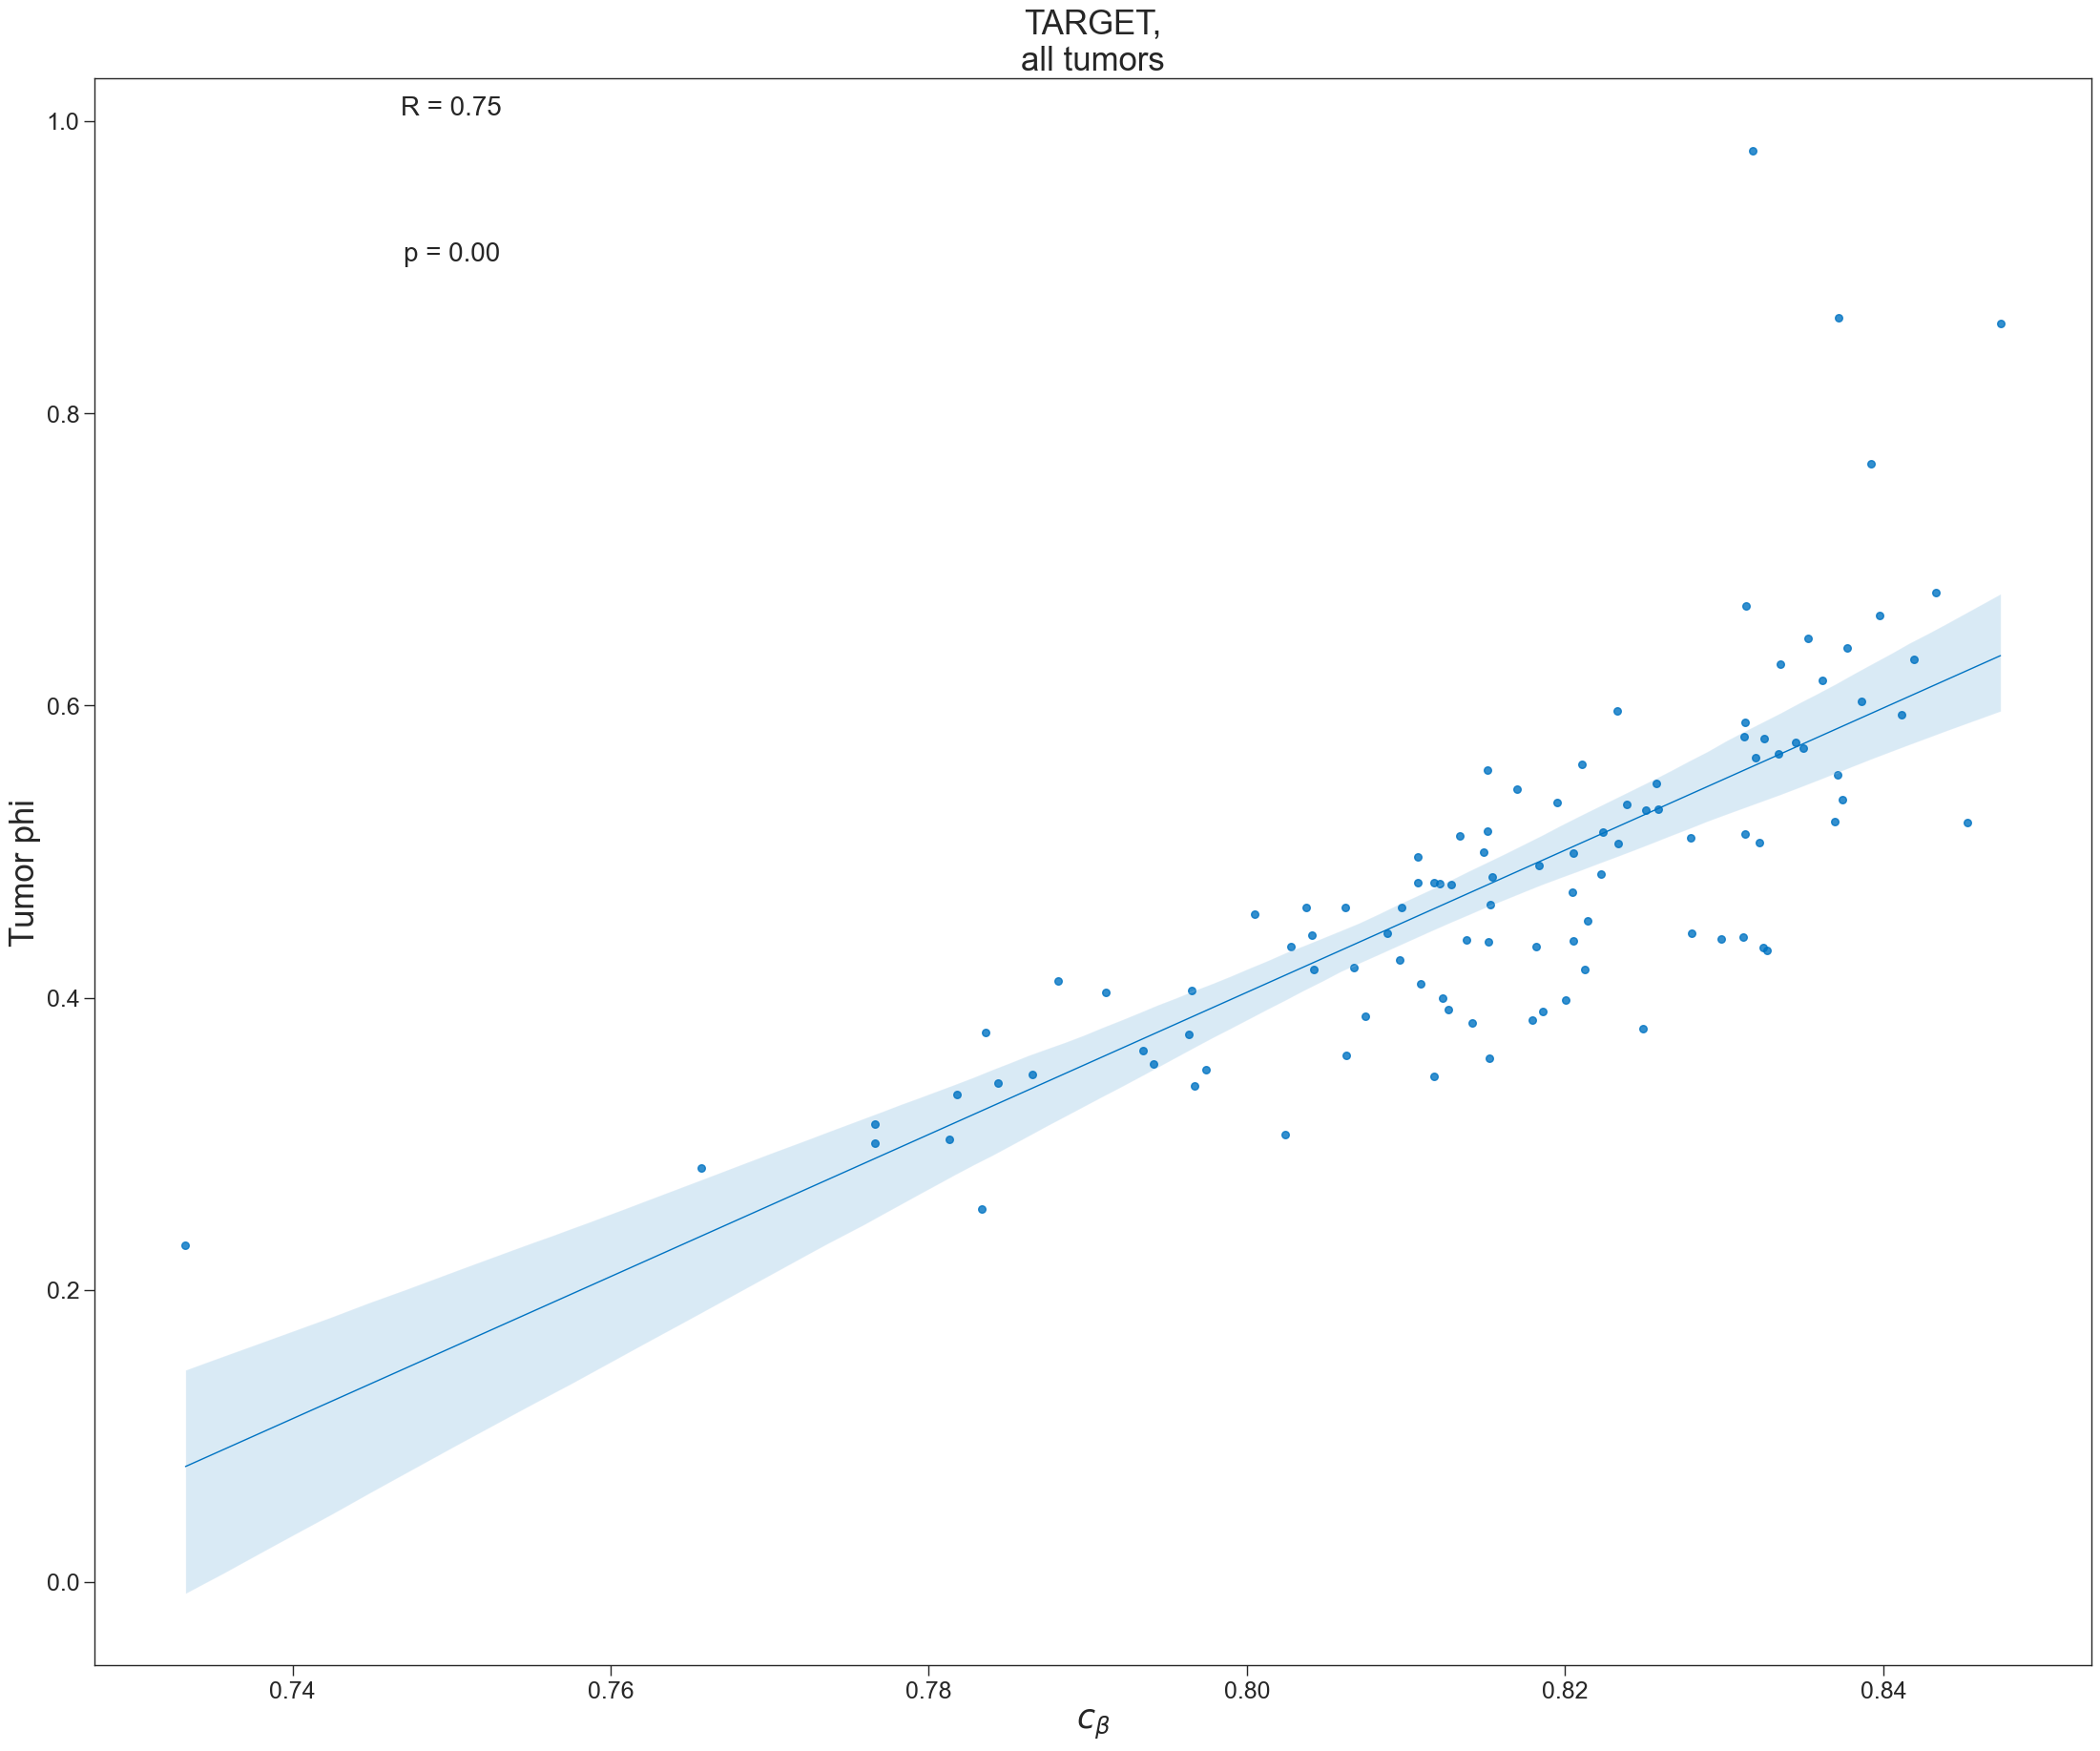

In [37]:
dataset = 'HEINRICH'

# Generate correlation results
cor_res = pc_util.getCorrelation(clinical["HEINRICH"], 'c_beta', 'gmm_phi')

# Plot correlation
fig, ax = plt.subplots(figsize=np.array([30, 24]) * 0.9 * sf)
text_x, text_y = 0.75, 1
pc_util.saveCorrelationPlot(clinical["HEINRICH"], var_y='gmm_phi',
                           var_x='c_beta',
                           outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
                           restrict=False,
                           xlabel='Patient age at diagnosis (years)', ylabel='Tumor phi',
                           labelfontsize=nbl_consts['labelfontsize'], ticksfontsize=nbl_consts['ticksfontsize'], sf=sf, s=30,
                           color=nbl_consts['palette_jco'][0], line_kws={'linewidth': 1 * sf})

# Add p-value to plot
ax.text(text_x, text_y-0.1, f'p = {cor_res.pvalue:.2f}',
        ha="center", va="bottom",
        fontfamily='sans-serif', fontsize=0.8 * nbl_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nall tumors', fontsize=nbl_consts['labelfontsize'] * sf)

plt.show()

In [36]:
column_A = clinical[dataset]['c_beta']
column_B = clinical[dataset]['gmm_phi']

# Compute Spearman rank correlation coefficient
spearman_corr, p_value = spearmanr(column_A, column_B)

print(spearman_corr)
print(p_value)

0.8189715944432925
1.3620144861147816e-26
